In [1]:
!pip install swifter

In [26]:
import json
import os
    
import pandas as  pd
import spacy
    
import seaborn as sns
import string

from tqdm import tqdm
from textblob import TextBlob
    
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import re
    
    
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
    
    
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
    
import swifter
import nltk
import numpy as np

In [3]:
data= pd.read_excel('DATA GP.xlsx')
df= pd.DataFrame(data)
df.head(5)

,Feedback,Topics,Sub-Topics,Club,Sub-Topics Labels
0,I never received my cheque two times cheque ca...,1,0,10,Lack of Transparency
1,everything is a disaster everything is a excus...,3,0,30,Poor Communication
2,Claim is taking over a three call to see what ...,3,0,30,Poor Communication
3,Have agent available to come to your home and ...,0,0,0,Outdated Process
4,Your company has gone down hill. I will recomm...,1,1,11,Documentation Issue


<AxesSubplot:>

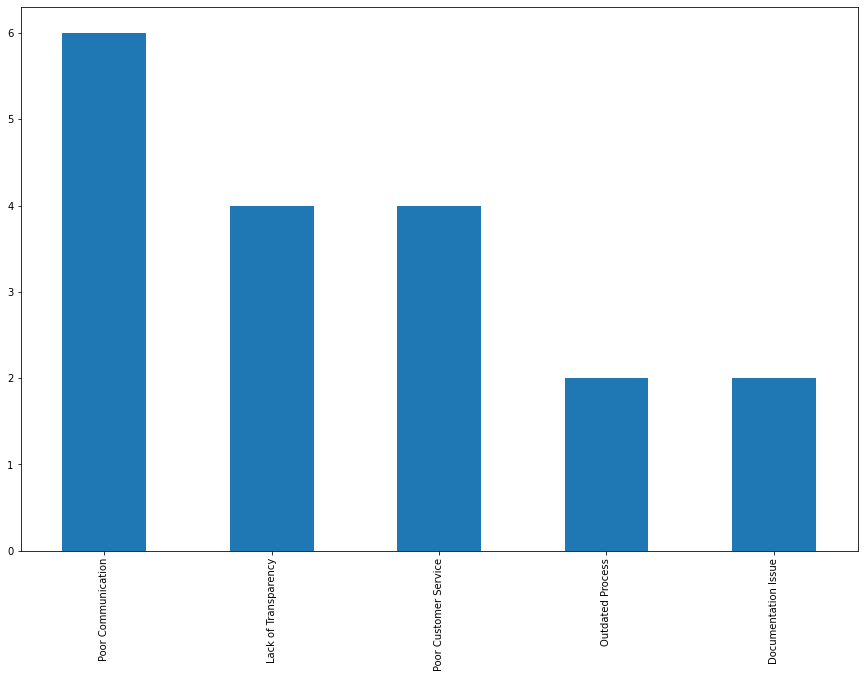

In [4]:
df['Sub-Topics Labels'].value_counts().plot( kind='bar', figsize=(15,10))


In [5]:
df.columns

Index(['Feedback', 'Topics', 'Sub-Topics', 'Club', 'Sub-Topics Labels'], dtype='object')

In [6]:
df.isna().sum()

Feedback             2
Topics               0
Sub-Topics           0
Club                 0
Sub-Topics Labels    4
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df.isna().sum()

Feedback             0
Topics               0
Sub-Topics           0
Club                 0
Sub-Topics Labels    0
dtype: int64

In [9]:
df.shape

(17, 5)

In [10]:
df['Sub-Topics Labels'].unique()

array(['Lack of Transparency', 'Poor Communication', 'Outdated Process',
       'Documentation Issue', 'Poor Customer Service'], dtype=object)

In [11]:
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()

In [12]:
def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2

In [13]:
def clean_txt(text):
    clean_text = []
    clean_text2 = []
    text = re.sub("'", "",text)
    text=re.sub("(\\d|\\W)+"," ",text)    
    clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
    clean_text2 = [word for word in clean_text if black_txt(word)]
    return " ".join(clean_text2)

In [14]:
def subj_txt(text):
    return  TextBlob(text).sentiment[1]

In [15]:
def polarity_txt(text):
    return TextBlob(text).sentiment[0]

In [16]:
def len_text(text):
    if len(text.split())>0:
         return len(set(clean_txt(text).split()))/ len(text.split())
    else:
         return 0

In [17]:
df['Feedback_N'] = df['Feedback'].swifter.apply(clean_txt)
df['polarity'] = df['Feedback_N'].swifter.apply(polarity_txt)
df['subjectivity'] = df['Feedback_N'].swifter.apply(subj_txt)
df['len'] = df['Feedback_N'].swifter.apply(lambda x: len(x))


Pandas Apply:   0%|          | 0/17 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/17 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/17 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/17 [00:00<?, ?it/s]

In [18]:
X = df[['Feedback_N', 'polarity', 'subjectivity','len']]
y =df['Sub-Topics Labels']

encoder = LabelEncoder()
y = encoder.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)
v = dict(zip(list(y), df['Sub-Topics Labels'].to_list()))

In [31]:
x_train

,Feedback_N,polarity,subjectivity,len
4,company hill recommend people work drop polici...,0.000000,0.000000,54
17,communication constant red tape try talk,0.000000,0.166667,40
13,nobody call back get cancel debit card change ...,0.000000,0.000000,61
1,everything disaster everything excuse claim li...,-0.050000,0.050000,65
16,chelsea great dennis absolute failure good,0.345833,0.637500,42
11,guy worst service ever,-1.000000,1.000000,22
15,nothing insurance something think talk abount ...,0.000000,0.000000,108
18,costly,0.000000,0.000000,6


In [19]:
text_clf = Pipeline([
...     ('vect', CountVectorizer(analyzer="word", stop_words="english")),
...     ('tfidf', TfidfTransformer(use_idf=True)),
...     ('clf', MultinomialNB(alpha=.01)),
... ])

In [20]:
text_clf.fit(x_train['Feedback_N'].to_list(), list(y_train))

Pipeline(steps=[('vect', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB(alpha=0.01))])

testing

In [21]:
X_TEST = x_test['Feedback_N'].to_list()
Y_TEST = list(y_test)

In [22]:
predicted = text_clf.predict(X_TEST)

In [23]:
c = 0

for doc, category in zip(X_TEST, predicted):
    
    if c == 2:break
    
    print("-"*55)
    print(doc)
    print(v[category])
    print("-"*55)

    c = c + 1 

-------------------------------------------------------
policy scam combine ready take customers money every month
Lack of Transparency
-------------------------------------------------------
-------------------------------------------------------
someone talk tape machine monitor anyone callls dont talk anyone end cancel insurance
Poor Communication
-------------------------------------------------------


In [27]:
np.mean(predicted == Y_TEST)

0.3333333333333333

Prediction

In [28]:
docs_new = ['outdated']

In [29]:
predicted = text_clf.predict(docs_new)

In [30]:
v[predicted[0]]

'Lack of Transparency'

Saving the model

In [ ]:
import pickle
with open('model.pkl','wb') as f:
    pickle.dump(text_clf,f)

In [ ]:
# load
with open('model.pkl', 'rb') as f:
    clf2 = pickle.load(f)

In [ ]:
docs_new = ['very poor service']
predicted = clf2.predict(docs_new)

In [ ]:
v[predicted[0]]